## 📊 Forecasting Patient Uptake for Drug X from Incidence and Trait Prevalence

This project simulates the number of patients treated with **Drug X** over time, using a minimal-input model based on:
- Tumor incidence
- Trait prevalence (e.g., HER2 expression, BRAF mutation)

It models physician adoption and treatment behavior probabilistically to estimate monthly treated patients over a 5–10 year period post-launch.


## Introduction

Imagine you're preparing to launch a new product, **Drug X**, within the next 2–3 years.

Your goal is to create a **preliminary forecast** of how many patients will be treated with Drug X **each month** over a **5- to 10-year period post-launch**.

The forecast is based on just two key inputs:
- **Tumor incidence** – number of new cases per year
- **Trait prevalence** – % of patients with a drug-relevant trait (e.g., **HER2 receptor expression**, **BRAF mutation**, that makes tumor responsive to Drug X ).

This approach allows for a quick and transparent assessment of potential market size.


## Data Generation Process

The diagram below shows how the simulation models each step in a patient’s journey—from eligibility to treatment duration.

Each stage includes uncertainty, modeled with appropriate probability distributions.

![Diagram](../images/DGP_Diagram.jpg)

### Key Concepts Behind the Model

1. **Probabilistic modeling** at each step to reflect real-world variability.
2. **Gradual physician adoption** of Drug X, peaking after 3 years.
3. **Partial treatment rates**, since doctors don’t prescribe to all eligible patients.

In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt

## Step-by-Step: Simulating Monthly Treated Patients

### 1. Eligible Patients per Month
- Modeled as a **Poisson distribution** based on annual epidemiological incidence.
- Optional: Add uncertainty to λ using a **uniform distribution**.


In [2]:
# Step 1: Simulate number of eligible patients per month
def simulate_monthly_eligibles(annual_eligibles, n_months, start_date=None, fluctuation_pct=0.025):
    """
    Simulates the number of monthly eligible patients over time using a Poisson process.

    Parameters:
    annual_eligibles (int): Number of eligible patients per year.
    n_months (int): Number of months to simulate.
    start_date (str, optional): Start date (YYYY-MM-DD). Defaults to first day of current month.
    fluctuation_pct (float, optional): Percent fluctuation in monthly incidence (default is 2.5%).

    Returns:
    pd.DataFrame: DataFrame indexed by month with simulated "Eligible_pts".
    """
    if start_date is None:
        start_date = pd.Timestamp.today().replace(day=1).strftime("%Y-%m-%d")
        
    avg_monthly = annual_eligibles / 12
    monthly_fluctuation = np.random.uniform(1 - fluctuation_pct, 1 + fluctuation_pct, n_months)
    monthly_counts = np.random.poisson(avg_monthly * monthly_fluctuation, n_months)
    date_index = pd.date_range(start=start_date, periods=n_months, freq="M")
    
    return pd.DataFrame({'Eligible_pts': monthly_counts}, index=date_index)

Visualizing the output of `simulate_monthly_eligibles()` function:

<Axes: title={'center': '5.0 Year monthly forecast of patients eligible to Drug X'}, xlabel='Time', ylabel='Nr of patients'>

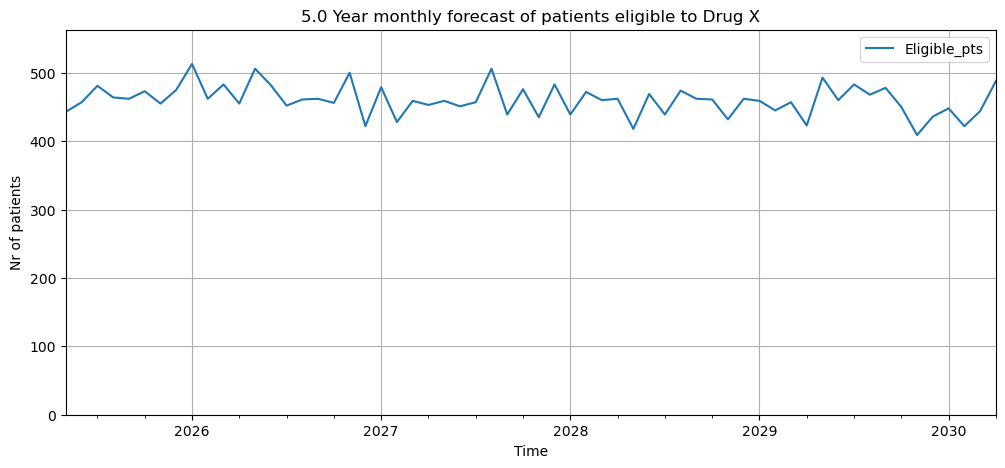

In [3]:
df = simulate_monthly_eligibles(annual_eligibles=5500, n_months=60)
df.plot(figsize=(12,5), ylim=(0, df['Eligible_pts'].max()+50), grid=True, 
        title=f'{len(df)/12} Year monthly forecast of patients eligible to Drug X',
        ylabel='Nr of patients',
        xlabel='Time')

### 2. Patients Seen by a User
- Binomial distribution: 
  - **n** = eligible patients
  - **p** = % of doctors using Drug X (adoption curve)
- **p** may be uncertain and modeled via **uniform** distribution, with its mean set to your best estimate of % of prescribers. It increases over time.

In [4]:
# Step 2: Patients Seen by a Prescriber
def simulate_pts_seen_by_users(eligible_df, max_user_share=0.70, initial_user_share=0.10,
                                share_uncertainty=0.05, months_to_peak=36):
    """
    Adds a column to the DataFrame with the number of eligible patients seen by users of Drug X each month,
    assuming linear user adoption over time with uncertainty.

    Parameters:
    eligible_df (pd.DataFrame): DataFrame with 'Eligible_pts' column (monthly eligible patients).
    max_user_share (float): Maximum share of doctors using Drug X (e.g., 0.70).
    initial_user_share (float): Initial share of users at launch (e.g., 0.10).
    share_uncertainty (float): +/- uncertainty on user share (e.g., 0.05).
    months_to_peak (int): Number of months to reach max_user_share (default 36 months).

    Returns:
    pd.DataFrame: Modified DataFrame with new column 'Pts_seen_by_users'.
    """
    t = np.arange(len(eligible_df))

    # Linear ramp-up in user share over time
    base_share = initial_user_share + (max_user_share - initial_user_share) * (t / months_to_peak)
    base_share = np.clip(base_share, 0, max_user_share)

    # Add uncertainty range
    p_min = np.clip(base_share - share_uncertainty, 0, 1)
    p_max = np.clip(base_share + share_uncertainty, 0, 1)

    # Sample individual probabilities for each time step
    user_probs = np.random.uniform(p_min, p_max)

    # Simulate how many eligible patients are seen by users
    seen_by_users = np.random.binomial(n=eligible_df['Eligible_pts'].values, p=user_probs)

    eligible_df = eligible_df.copy()
    eligible_df['Pts_seen_by_users'] = seen_by_users

    return eligible_df

Visualizing the output of `simulate_pts_seen_by_users()` function:

<Axes: title={'center': '5.0 Year monthly forecast of patients eligible to Drug X'}, xlabel='Time', ylabel='Nr of patients'>

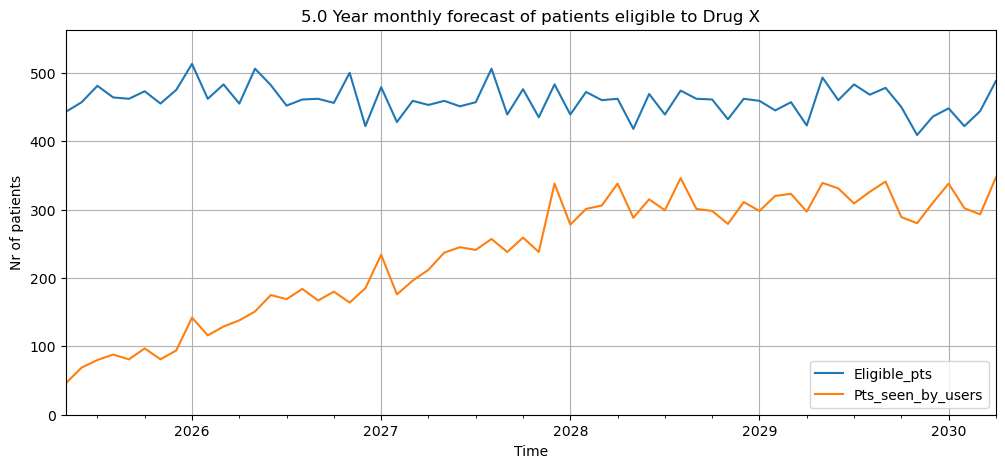

In [5]:
df = simulate_pts_seen_by_users(eligible_df=df)
df.plot(figsize=(12,5), ylim=(0, df['Eligible_pts'].max()+50), grid=True, 
        title=f'{len(df)/12} Year monthly forecast of patients eligible to Drug X',
        ylabel='Nr of patients',
        xlabel='Time')

### 3. Patients Prescribed Drug X
- Another **binomial** process:
  - **n** = patients seen by prescribers
  - **p** = % likelihood of prescribing Drug X
- **p** can also be treated as uncertain and modeled with a **uniform** distribution, with its mean set to your best estimate of likelihood of prescribing the drug.

In [6]:
# Step 3: Patients Prescribed Drug X
def simulate_new_pts_treated(user_seen_df, mean_treatment_prob=0.25, treatment_uncertainty=0.05):
    """
    Adds a column to the DataFrame with the number of patients actually treated with Drug X,
    among those seen by users, accounting for prescribing uncertainty.

    Parameters:
    user_seen_df (pd.DataFrame): DataFrame with column 'Pts_seen_by_users'.
    mean_treatment_prob (float): Mean probability a user prescribes Product X (default: 0.25).
    treatment_uncertainty (float): Range for uniform fluctuation around the mean (default: ±5%).

    Returns:
    pd.DataFrame: Modified DataFrame with new column 'New_pts_treated'.
    """
    n_months = len(user_seen_df)

    # Simulate variable prescribing probability over time
    treatment_probs = np.random.uniform(
        low=np.clip(mean_treatment_prob - treatment_uncertainty, 0, 1),
        high=np.clip(mean_treatment_prob + treatment_uncertainty, 0, 1),
        size=n_months
    )

    new_treated = np.random.binomial(n=user_seen_df['Pts_seen_by_users'].values, p=treatment_probs)

    user_seen_df = user_seen_df.copy()
    user_seen_df['New_pts_treated'] = new_treated

    return user_seen_df

Visualizing the output of `simulate_new_pts_treated()` function:

<Axes: title={'center': '5.0 Year monthly forecast of patients eligible to Drug X'}, xlabel='Time', ylabel='Nr of patients'>

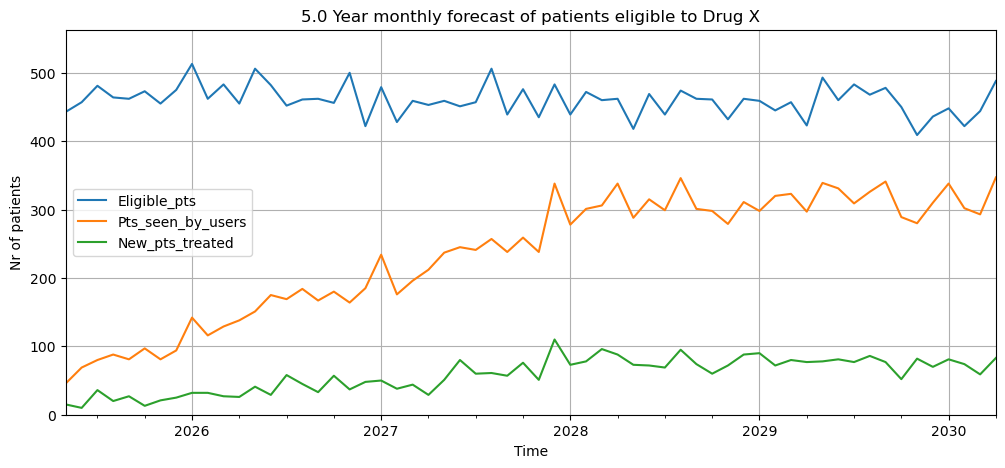

In [7]:
df = simulate_new_pts_treated(user_seen_df=df)
df.plot(figsize=(12,5), ylim=(0, df['Eligible_pts'].max()+50), grid=True, 
        title=f'{len(df)/12} Year monthly forecast of patients eligible to Drug X',
        ylabel='Nr of patients',
        xlabel='Time')

### 4. Duration on Treatment
- Modeled with an **exponential** distribution with median λ (e.g., **10 months**), based on clinical data or expert assumptions.
- Example: Median 10 months, capped at 12.

In [8]:
# Step 4: Duration on Treatment
def simulate_treatment_persistence(n_new_treated, median_duration_months=10, max_duration_months=None):
    """
    Simulates how many of the newly treated patients remain on treatment
    over time, optionally capped at a max duration.

    Parameters:
    n_new_treated (int): Number of new patients starting treatment.
    median_duration_months (float): Median treatment duration (default 10 months).
    max_duration_months (int or None): Maximum duration to consider (e.g., 12 for 12 months, 
        or None for full duration).

    Returns:
    List[int]: Number of patients still on treatment at each month.
    """
    scale = median_duration_months / np.log(2)
    durations = np.random.exponential(scale=scale, size=n_new_treated)

    if max_duration_months is None:
        max_month = int(np.ceil(durations.max()))
    else:
        max_month = max_duration_months

    patients_remaining = [np.sum(durations > month) for month in range(max_month)]

    return patients_remaining

Visualizing the output of `simulate_treatment_persistence()` function for lifelong treatments:

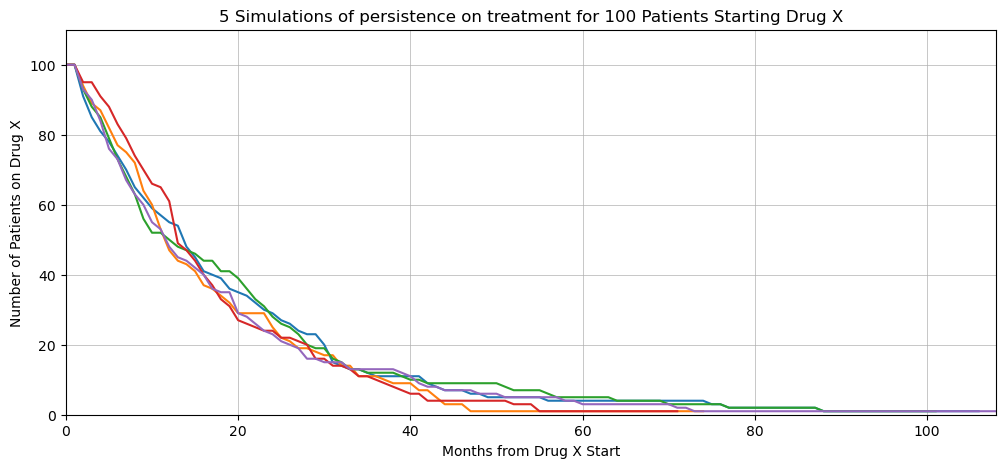

In [ ]:
plt.figure(figsize=(12, 5))

for _ in range(5):
    persistence = simulate_treatment_persistence(n_new_treated=100,
                                                 median_duration_months=12,
                                                 max_duration_months=None)
    
    persistence = [100] + persistence  # Add Month 0 where all patients are on treatment
    months = range(len(persistence))   # Now includes 0

    plt.plot(months, persistence)

# Labels and formatting
plt.xlabel('Months from Drug X Start')
plt.ylabel('Number of Patients on Drug X')
plt.title('5 Simulations of persistence on treatment for 100 Patients Starting Drug X')
plt.grid(which="major", linewidth=0.5)

plt.ylim(0, 110)
plt.xlim(0, len(persistence) - 1)

#plt.savefig("../images/persistence.png", dpi=300, bbox_inches='tight')

plt.show()

Visualizing the output of `simulate_treatment_persistence()` function for treatments with a specified number of months duration (e.g. 12 months):

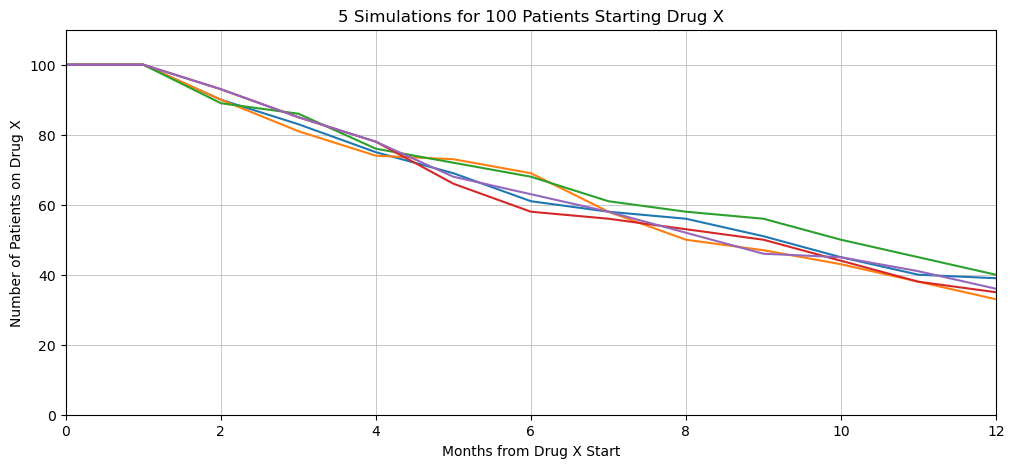

In [10]:
plt.figure(figsize=(12, 5))

for _ in range(5):
    persistence = simulate_treatment_persistence(n_new_treated=100,
                                                 median_duration_months=8,
                                                 max_duration_months=12)
    
    persistence = [100] + persistence  # Add Month 0 where all patients are on treatment
    months = range(len(persistence))   # Now includes 0

    plt.plot(months, persistence)

# Labels and formatting
plt.xlabel('Months from Drug X Start')
plt.ylabel('Number of Patients on Drug X')
plt.title('5 Simulations for 100 Patients Starting Drug X')
plt.grid(which="major", linewidth=0.5)

plt.ylim(0, 110)
plt.xlim(0, len(persistence) - 1)

plt.show()

### 📈 Final Output: Simulating Patients on Treatment Over Time
This function calculates the number of patients who remain on **Drug X** each month after starting treatment. It models how long each newly treated patient stays on therapy using an exponential distribution, based on a specified **median treatment duration**.

The function is optimized for speed and scalability, making it suitable for running **large-scale simulations** (e.g., Monte Carlo forecasts). It supports both **lifelong treatments** and treatments with a **fixed maximum duration**.

The output is a monthly estimate of the number of patients on treatment, considering both new prescriptions and persistence over time.

In [11]:
def simulate_forecast(df, median_duration_months=10, max_duration_months=None):
    """
    Simulates the number of patients on Drug X each month based on treatment duration and uptake.

    Optimized for speed when scaling up to thousands of simulations.

    Parameters:
    - df (pd.DataFrame): Must contain 'New_pts_treated' column.
    - median_duration_months (float): Median duration patients stay on treatment.
    - max_duration_months (int or None): Max duration a patient can remain on treatment.

    Returns:
    - pd.DataFrame: Same DataFrame with 'Pts_on_treatment' column added.
    """
    n_months = len(df)
    treatment_window = max_duration_months if max_duration_months is not None else n_months
    persistence_matrix = np.zeros((n_months, treatment_window), dtype=int)

    # Simulate durations for all patients in a single pass (flat arrays, avoids Python loops)
    for month_idx, n_new in enumerate(df['New_pts_treated'].astype(int).values):
        if n_new == 0:
            continue
        # Simulate durations
        durations = np.random.exponential(scale=median_duration_months / np.log(2), size=n_new).astype(int)
        if max_duration_months:
            durations = np.clip(durations, 1, max_duration_months)
        else:
            durations = np.clip(durations, 1, n_months)

        # Count patients staying on treatment for at least t months
        for dur in durations:
            end = min(dur, treatment_window)
            persistence_matrix[month_idx, :end] += 1

    # Efficient diagonal summation to get calendar-month totals
    total_on_treatment = np.array([persistence_matrix[::-1, :].diagonal(i).sum()
                                   for i in range(-n_months + 1, treatment_window)])
    
    df['Pts_on_treatment'] = total_on_treatment[:n_months]
    return df

The graph below shows the simulated number of patients on treatment with Drug X over time, that is the output of the `simulate_forecast()` function:

<Axes: title={'center': '5.0 Year monthly forecast of patients eligible to Drug X'}, xlabel='Time', ylabel='Nr of patients'>

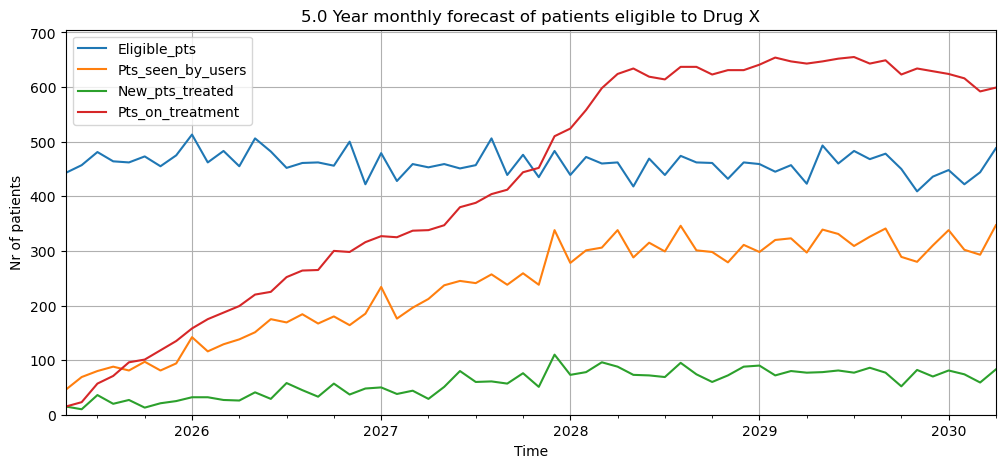

In [12]:
df = simulate_forecast(df, max_duration_months=12)
df.plot(figsize=(12,5), ylim=(0, df['Pts_on_treatment'].max()+50), grid=True, 
        title=f'{len(df)/12} Year monthly forecast of patients eligible to Drug X',
        ylabel='Nr of patients',
        xlabel='Time')

## Summary

This notebook uses a transparent, probabilistic model to forecast treated patients using only two epidemiological inputs. It accounts for uncertainty, physician behavior, and patient persistence on treatment.

### 🧩 Summary of Forecasting Functions
The following functions together simulate the entire process of forecasting the number of patients on treatment with **Drug X** over time. Each function plays a distinct role in the pipeline, and they work in sequence as follows:

1. `simulate_monthly_eligibles()`

    Simulates the number of newly eligible patients per month using a Poisson process with optional random fluctuations.

2. `simulate_pts_seen_by_users()`

    Estimates how many eligible patients are seen by doctors who prescribe Drug X, assuming a linear increase in user adoption with uncertainty.

3. `simulate_new_pts_treated()`

    Determines how many patients seen by users are actually prescribed Drug X, incorporating variability in prescribing behavior.

4. `simulate_treatment_persistence()`

    Models how long each newly treated patient remains on therapy, based on an exponential distribution with optional maximum duration.

5. `simulate_forecast()`
    
    Combines all the above components to estimate, for each month, the total number of patients on treatment by aggregating persistence across new prescriptions over time.

In [13]:
df.head()

,Eligible_pts,Pts_seen_by_users,New_pts_treated,Pts_on_treatment
2025-05-31,443,46,15,15
2025-06-30,457,69,10,23
2025-07-31,481,80,36,57
2025-08-31,464,88,20,71
2025-09-30,462,81,27,96
